In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy import stats
import tensorflow as tf
import seaborn as sns

from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import minmax_scale

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["up", "down"]

Using TensorFlow backend.


In [2]:
oecd선행지수=pd.read_excel('OECD 경기선행지수.xls')

In [3]:
oecd선행지수=oecd선행지수.iloc[108:-2,:]

In [4]:
경기선행지수=pd.read_csv('경기선행지수_RNN.csv')

In [5]:
경기선행지수.columns

Index(['Unnamed: 0', 'Brent', 'Dollar', 'Dubai', 'Euro', 'Lf', 'M2',
       'Tourism_balance', 'West_Texas', 'Yen', 'log_stock', 'yuan', '경상수지',
       '경제심리지수', '고용률', '공매도', '교역조건지수', '대만', '동행지수순환변동치', '미국채수익률',
       '선행지수순환변동치', '소비자물가지수', '수입금액지수', '수입물가지수', '수출금액지수', '수출물가지수',
       '신용카드사용액', '실업률', '일본', '주식거래대금', '중국', '호텔신라주가', '홍콩'],
      dtype='object')

In [6]:
oecd선행지수=oecd선행지수.reset_index()

In [7]:
oecd선행지수_list = []
for i in range(len(oecd선행지수)):
    oecd선행지수_list.append(oecd선행지수['OECD CLI'][i])

In [8]:
경기선행지수['oecd선행지수'] = oecd선행지수_list

In [9]:
경기선행지수['oecd선행지수']=list(minmax_scale(list(경기선행지수['oecd선행지수'])))

In [10]:
oecd선행지수_list=[]
for i in range(len(경기선행지수['oecd선행지수'])):
    if 경기선행지수['oecd선행지수'][i] < 0.30:##정규화된 선행지수가 0.3이하이면 경기이상이라고 생각한다.
        oecd선행지수_list.append(1)
    else:
        oecd선행지수_list.append(0)

In [11]:
경기선행지수['oecd선행지수'] = oecd선행지수_list

In [12]:
data = 경기선행지수
y_test = 경기선행지수['oecd선행지수']
del data['Unnamed: 0']

In [13]:
del data['선행지수순환변동치']

In [14]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
X_train = X_train[X_train.oecd선행지수 == 0]
X_train = X_train.drop(['oecd선행지수'], axis=1)

y_test = X_test['oecd선행지수']
X_test = X_test.drop(['oecd선행지수'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(28, 31)

In [35]:
encoder

<tf.Tensor 'dense_2/Relu:0' shape=(?, 14) dtype=float32>

In [16]:
input_dim = X_train.shape[1]
encoding_dim = 28

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="sigmoid", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="sigmoid")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='sigmoid')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 300
batch_size = 32##Autoencoder 코드
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame()
error_df['true_class'] = list(y_test)##실제값과
error_df['reconstruction_error'] = list(mse)##loss 값
error_df

Train on 28 samples, validate on 17 samples
Epoch 1/300
28/28 [==============================] - 0s 3ms/step - loss: 0.1137 - acc: 0.0000e+00 - val_loss: 0.1136 - val_acc: 0.0000e+00
Epoch 2/300
28/28 [==============================] - 0s 42us/step - loss: 0.1129 - acc: 0.0000e+00 - val_loss: 0.1130 - val_acc: 0.0000e+00
Epoch 3/300
28/28 [==============================] - 0s 48us/step - loss: 0.1120 - acc: 0.0000e+00 - val_loss: 0.1124 - val_acc: 0.0000e+00
Epoch 4/300
28/28 [==============================] - 0s 36us/step - loss: 0.1111 - acc: 0.0000e+00 - val_loss: 0.1118 - val_acc: 0.0000e+00
Epoch 5/300
28/28 [==============================] - 0s 49us/step - loss: 0.1103 - acc: 0.0000e+00 - val_loss: 0.1113 - val_acc: 0.0000e+00
Epoch 6/300
28/28 [==============================] - 0s 40us/step - loss: 0.1095 - acc: 0.0000e+00 - val_loss: 0.1107 - val_acc: 0.0000e+00
Epoch 7/300
28/28 [==============================] - 0s 36us/step - loss: 0.1087 - acc: 0.0000e+00 - val_loss: 0.1102

,true_class,reconstruction_error
0,0,0.048790
1,0,0.049310
2,0,0.075834
3,0,0.044206
4,0,0.049333
5,1,0.143306
6,0,0.100340
7,1,0.117195
8,1,0.157417
9,0,0.041211


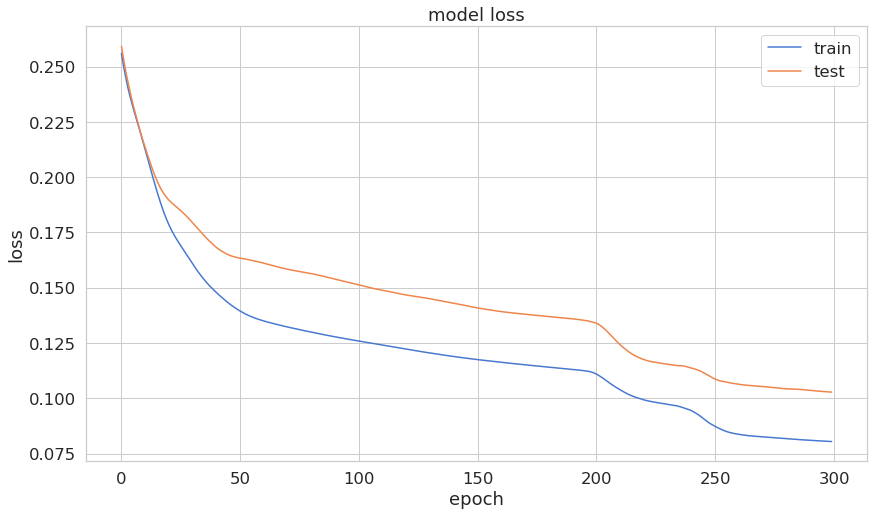

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

,true_class,reconstruction_error
0,0,0.047221
1,0,0.104550
2,0,0.090630
3,0,0.024273
4,0,0.089064
5,1,0.127837
6,0,0.057177
7,1,0.153991
8,1,0.148642
9,0,0.116409


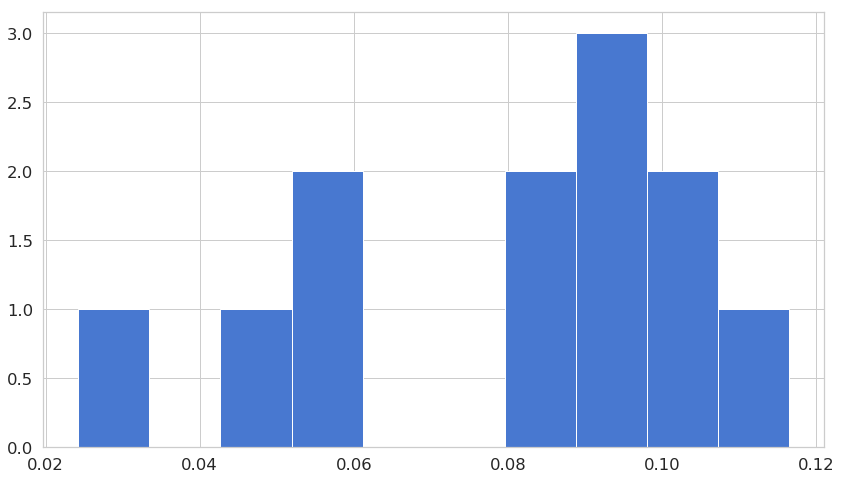

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

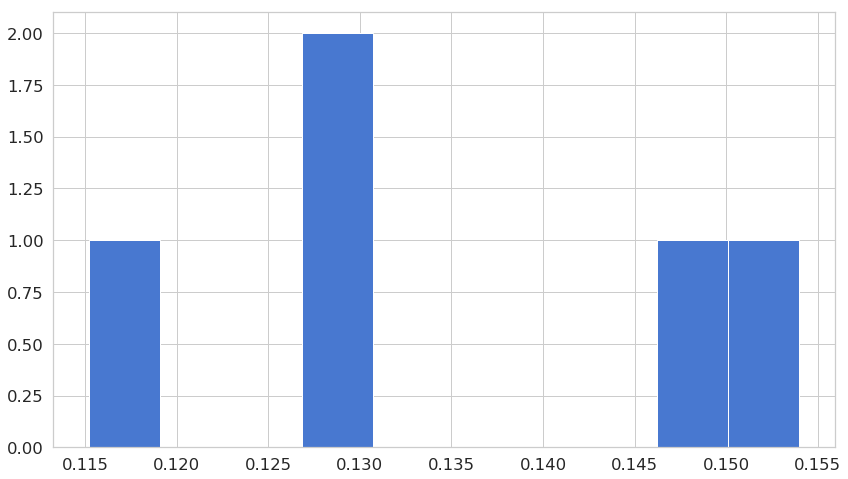

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [26]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

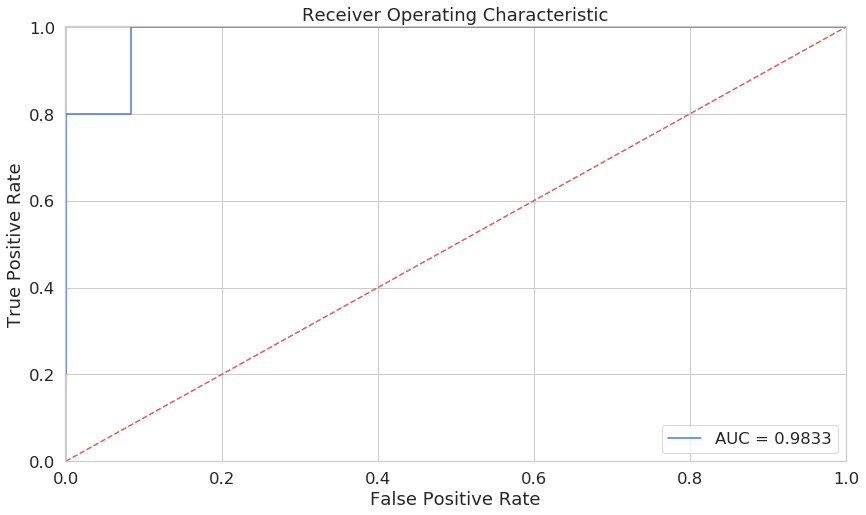

In [27]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


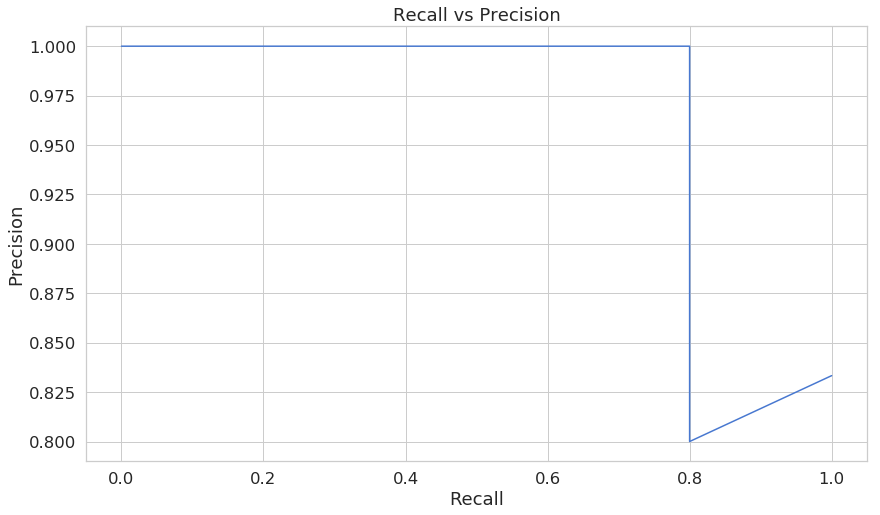

In [28]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

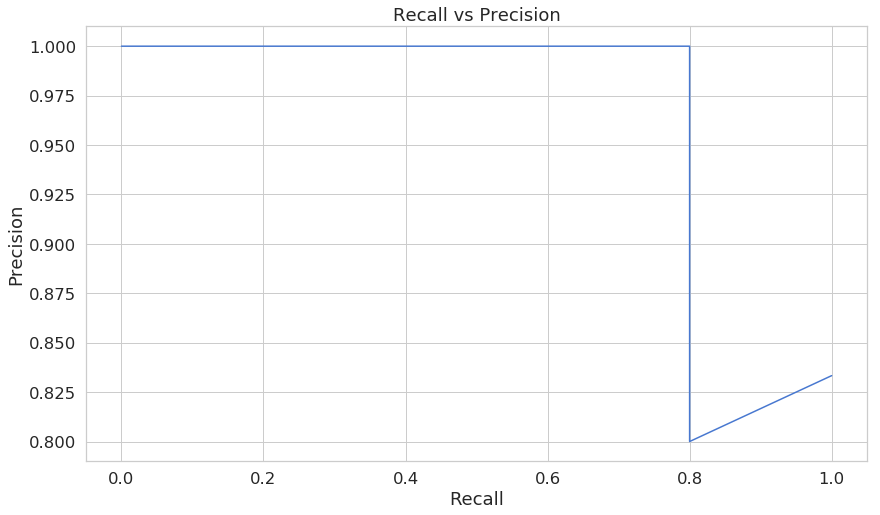

In [29]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [32]:
threshold = 0.11## error의 임계점 



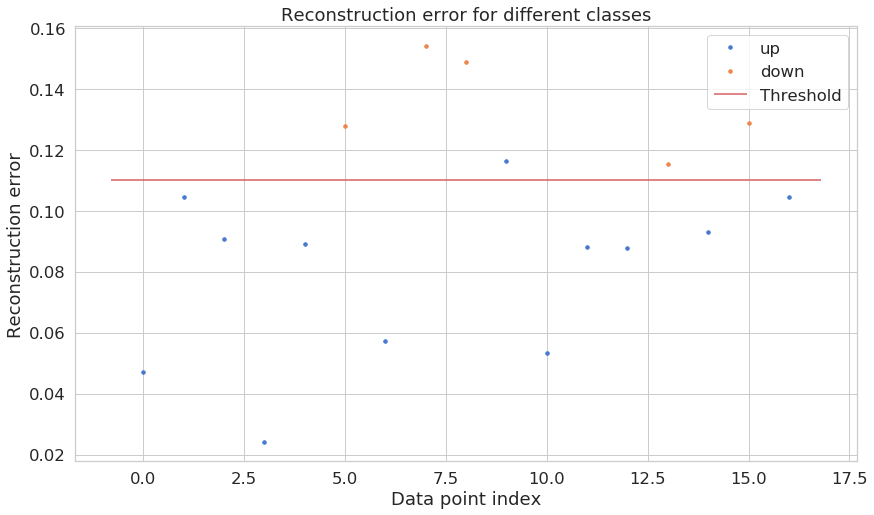

In [33]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "down" if name == 1 else "up")##up이면 경기이상이없고 down이면 경기이상이 있다.
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

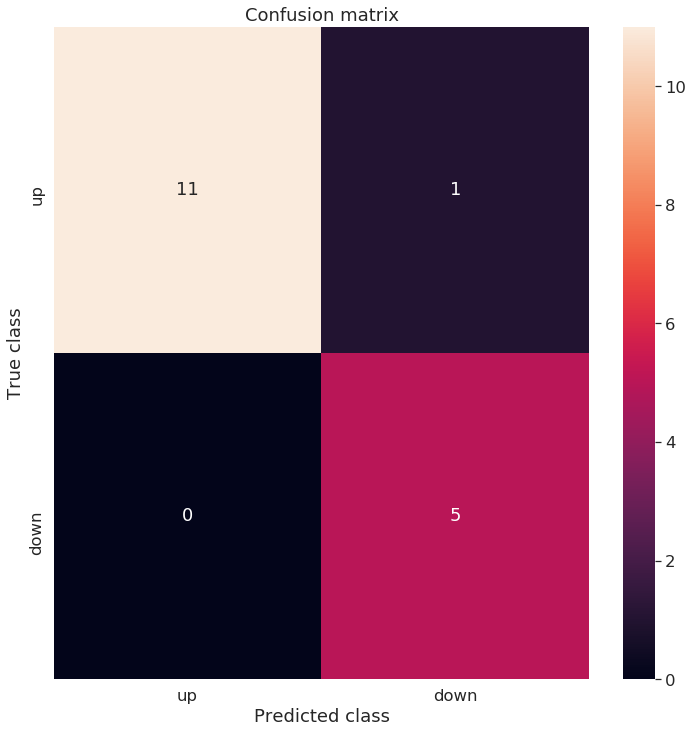

In [34]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()    